# Lưu ý : đặt train train.csv và test.csv lên drive như đừng dẫn 

In [25]:
from google.colab import drive

drive.mount("/content/drive")

import shutil

source = "./drive/MyDrive/train.csv"
destination = "./train.csv"
shutil.copy(source, destination)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'./train.csv'

In [26]:
!pip3 install torchtext

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset

In [28]:
batch_size = 32
epochs = 30
lr = 0.000001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Tiền xử lý dữ liệu
### 1.1 Tiền xử lý dữ liệu đầu vào
- Dữ liệu văn đầu vào bằng cách chuyển đổi thành một list token, vd: uchiha sasuke -> [uchiha,sasuke], sau đó tạo bảng chỉ mục cho token. Và chuyên đổi thành lowercase.</br>
- Chia dữ liệu ra thành dữ liệu train và dữ liệu validation theo tỷ lệ 80-20.


In [29]:
df = pd.read_csv("./train.csv")
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(
    df["full_text"], df["score"], test_size=0.2, stratify=df["score"]
)

tokenizer = get_tokenizer("spacy", language="en_core_web_sm")


def process_input(text):
    return tokenizer(text)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


### 1.2 Tiền xử lý label
Label giá trị trị từ 1-6 (cột score) là dữ liệu categorical.
 Nhưng để làm bài này, label phải là dữ liệu ordinary
 Biến đổi label CATEGORICAL SANG ORDINARY bằng cách :

 Encode label thành một vector nhị phân có độ dài 6, bit i bằng 1 nghĩa là đã thỏa yêu cầu i
 Các giá trị trong vector CHO BIẾT XÁC SUẤT VỊ TRÍ i THỎA YÊU CẦU i.
 Từ đó có thể sử dụng CROSS-ENTROPY để sử dụng hàm lỗi so sánh sự tương đồng giữa 2 phân phối.

 Từ trên ta tạo tính ORDINARY như sau:

 Bài được chấm điểm 1 <= i <= 6 nghĩa là đã thỏa mãn yêu cầu i, VÀ CŨNG THỎA TẤT CẢ CÁC YÊU CẦU TRƯỚC ĐÓ (<= i),
 nên các bit trong vector nhãn sẽ = 1 ở các vị trí <= i, và 0 ở các vị trí còn lại.
 Cách làm này giúp có TÍNH SO SÁNH, vì một khi được điểm j >= i, thì các bit 1 của điểm i cũng = 1 ở trong j

In [30]:
def process_label(category):
    y = int(category)
    z = np.zeros(6)
    z[:y] = 1
    return z

In [31]:
X_train = [process_input(text) for text in X_train_df]
X_val = [process_input(text) for text in X_val_df]
y_train = [process_label(label) for label in y_train_df]
y_val = [process_label(label) for label in y_val_df]

## 2. Build chỉ mục tư điển và tạo dataset

- `vocab`: để build chỉ mục tương ứng cho từng token của dữ liệu.

In [32]:
vocab = build_vocab_from_iterator(iter(X_train), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])


class ModelDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        tokens = self.X[idx]
        label = self.y[idx]
        return tokens, label


train_ds = ModelDataset(X_train, y_train)
valid_ds = ModelDataset(X_val, y_val)

- Viết hàm `collate_batch` để tiền xử lý các dữ liệu trong cùng 1 lô, đảm bảo các dũ liệu trong lô có cùng độ dài.
- `pad_sequence`: dùng để padd cho các sequence cùng một lô có cùng độ dài.
- Hàm trả về tuple có thêm một đối tượng `sequence length` dùng để gọi hàm `nn.utils.rnn.pack_padded_sequence`

In [33]:
def collate_batch(batch):
    inputs, seq_lengths, labels = [], [], []
    for tokens, label in batch:
        seq = torch.tensor(vocab(tokens), dtype=torch.int64)
        inputs.append(seq)
        seq_lengths.append(seq.size(0))
        labels.append(label)
    inputs = pad_sequence(inputs, padding_value=vocab["<pad>"])
    seq_lengths = torch.tensor(seq_lengths, dtype=torch.int64)
    labels = torch.tensor(labels, dtype=torch.float)

    seq_lengths, perm_idx = seq_lengths.sort(dim=0, descending=True)

    inputs = inputs.transpose(0, 1)
    inputs = inputs[perm_idx]
    inputs = inputs.transpose(0, 1)

    labels = labels[perm_idx]

    return (
        inputs.to(device),
        seq_lengths.to(device),
        labels.to(device),
    )


train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_batch
)
valid_loader = DataLoader(
    valid_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_batch
)

## 3. Build model

In [34]:
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 256
output_dim = 6
n_layers = 2
bidirectional = True
padding_idx = vocab["<pad>"]
unk_idx = vocab["<unk>"]

In [35]:
class Rnn_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings = vocab_size, embedding_dim= embedding_dim, padding_idx=padding_idx
        )

        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=0.5,
        )
        self.fc = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, text, text_lengths):
        x = self.embedding(text)
        x = self.dropout(x)
        packed = nn.utils.rnn.pack_padded_sequence(
            x, text_lengths.to("cpu")
        )
        packed_output, (hidden, cell) = self.lstm(packed)
        x = hidden.view(hidden.shape[1],-1)
        x = self.dropout(x)
        return self.fc(x)


model = Rnn_Model()

## 3. Train Model

In [36]:
import time


optimizer = optim.Adam(model.parameters(),lr=lr)

model = model.to(device)
criterion = nn.BCEWithLogitsLoss().to(device)

train_loss = []
val_loss = []
for epoch in range(epochs):
    epoch_time = time.time()

    epoch_loss = 0
    batch_cnt = 0

    model.train()
    for inputs, text_lengths, labels in train_loader:
        optimizer.zero_grad()

        output = model(inputs, text_lengths)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_cnt+=1

    train_loss.append(epoch_loss/batch_cnt)

    model.eval()
    epoch_loss = 0
    batch_cnt = 0
    for inputs, text_lengths, labels in valid_loader:

        output = model(inputs, text_lengths)
        loss = criterion(output, labels)

        epoch_loss += loss.item()
        batch_cnt += 1

    val_loss.append(epoch_loss/batch_cnt)
    print(
        "End epoch",
        epoch+1,
        "on",
        format(time.time() - epoch_time, ".3f"),
        "seconds with loss:",
        format(train_loss[-1], ".3f"),
        "val_loss:",
        format(val_loss[-1],'.3f'),
    )

End epoch 1 on 66.816 seconds with loss: 0.689 val_loss: 0.686
End epoch 2 on 58.961 seconds with loss: 0.684 val_loss: 0.680
End epoch 3 on 57.624 seconds with loss: 0.679 val_loss: 0.674
End epoch 4 on 58.029 seconds with loss: 0.673 val_loss: 0.668
End epoch 5 on 57.498 seconds with loss: 0.667 val_loss: 0.661
End epoch 6 on 57.812 seconds with loss: 0.659 val_loss: 0.652
End epoch 7 on 59.691 seconds with loss: 0.651 val_loss: 0.642
End epoch 8 on 58.465 seconds with loss: 0.640 val_loss: 0.629
End epoch 9 on 57.478 seconds with loss: 0.627 val_loss: 0.612
End epoch 10 on 59.315 seconds with loss: 0.609 val_loss: 0.586
End epoch 11 on 57.884 seconds with loss: 0.577 val_loss: 0.535
End epoch 12 on 58.605 seconds with loss: 0.495 val_loss: 0.428
End epoch 13 on 59.896 seconds with loss: 0.424 val_loss: 0.403
End epoch 14 on 58.263 seconds with loss: 0.405 val_loss: 0.390
End epoch 15 on 58.184 seconds with loss: 0.394 val_loss: 0.380
End epoch 16 on 59.458 seconds with loss: 0.385 v

## 4. Export model và thống kê lỗi

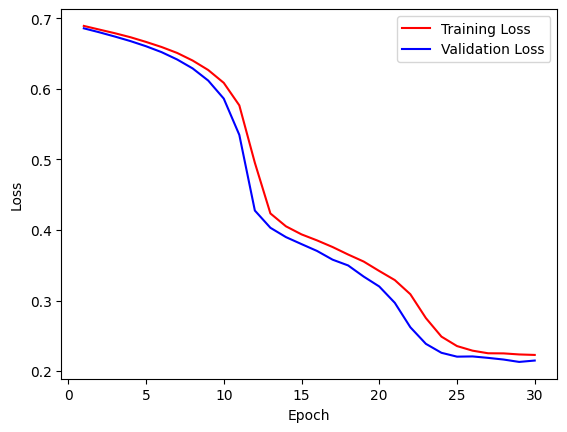

In [37]:
torch.save(model.state_dict(), "model.pth")


import matplotlib.pyplot as plt

epoch_rows = range(1, epochs + 1)
plt.plot(epoch_rows, train_loss, "r-")
plt.plot(epoch_rows, val_loss, "b-")
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.savefig("Loss_plot.png")
plt.show()

## 5. Chấm điểm cho dữ liệu test

In [41]:
def collate(tokens_list):
    inputs, seq_lengths = [], []
    for tokens in tokens_list:
        seq = torch.tensor(vocab(tokens), dtype=torch.int64)
        inputs.append(seq)
        seq_lengths.append(seq.size(0))
    inputs = pad_sequence(inputs, padding_value=vocab["<pad>"])
    seq_lengths = torch.tensor(seq_lengths, dtype=torch.int64)

    seq_lengths, perm_idx = seq_lengths.sort(dim=0, descending=True)

    inputs = inputs.transpose(0, 1)
    inputs = inputs[perm_idx]
    inputs = inputs.transpose(0, 1)

    return (
        inputs.to(device),
        seq_lengths.to(device),
    )



shutil.copy("./drive/MyDrive/test.csv", "./test.csv")
test_df = pd.read_csv("./test.csv")
X_test = [process_input(text) for text in test_df['full_text']]
test_inputs,test_seq_lengths = collate(X_test)

model_test = Rnn_Model()
model_test.load_state_dict(torch.load("./model.pth"))
model_test.to(device)
model_test.eval()

predicts = model_test(test_inputs,test_seq_lengths)


for i in range(len(test_df)):
    predict = predicts[i]
    print(test_df.iloc[i]["essay_id"], ": ",(predict >= 0.5).sum().item())

000d118 :  4
000fe60 :  3
001ab80 :  2


## 6. Một vài ví dụ cho dữ liệu train

In [43]:
df_sample = df.sample(n=5)
sample_X = [process_input(text) for text in df_sample["full_text"]]
sample_inputs, sample_seq_lengths = collate(sample_X)

predicts = model_test(sample_inputs, sample_seq_lengths)

for i in range(len(predicts)):
    predict = predicts[i]
    print("\033[1;32mTruth Score: \033[0m", df_sample.iloc[i]["score"])
    print("\033[1;36mPrediction: \033[0m", (predict >= 0.5).sum().item())
    print("\033[1;33mEssay: \033[0m", df_sample.iloc[i]["full_text"])
    print("\n")
    if i != len(predicts) - 1:
        print(100 * "-", "\n")

Truth Score:  3
Prediction:  4
Essay:  The usage of cars around the whole world has been the main reason why the earth is facing with air pollution problems and day by day our ozone layer is breaking. To solve this problem we can limit the usage of cars or any type of moving vehicle that can harm us and use other efficient ways to get to places.

There have been places in this world where they have started to move to make a difference in the earth. For example in source one "Vauban's streets are completely "car-free" except the main thoroughfare, where the tram to downtown Freiburg runs..." in Vauban, Germany there are alot of suburban communities who have giving up using cars or have sold their cars to make their houses where they live. Not only have they be making car free streets but also have taken out parking spaces so that people can reduce the usage of cars. This change can be either economicaly better for everyone but can also be useful for people to start thinking to go outsid